Curve fitting is an important tool for predictive modeling.  While univarate and bivarate data are relatively common and relatively straightforward to model, there are many cases in which the data is higher-dimensional, both for independent and dependent variables.  I enjoy using the 'lmfit' (https://lmfit.github.io/lmfit-py/index.html) package for curve fitting, but generalizing to higher dimensional data can be bit trickier.  There's a brief FAQ (https://lmfit.github.io/lmfit-py/faq.html) that touches on tackling these issues, but I think a more detailed tutorial could be helpful.

In the following post I will:
    1. Generate and visualize multidimensional data.
    2. Handle the bookkeeping for this data using pandas (https://pandas.pydata.org/).
    3. Fit a subset of the data using lmfit.
    4. Visualize the best fit model.

## Generating Data

Let's say I have a 3D vector field, $\vec{E}$, and each component of my field can be expressed by the following set of equations:

$$E_x(x,y,z) = \sum^M_m\sum^N_n\left[A_{m,n}m\pi\cos(m \pi x)\sin(n \pi y)\sinh(k_{m,n} z)\right]\\
E_y(x,y,z) = \sum^M_m\sum^N_n\left[A_{m,n}n\pi\sin(m \pi x)\cos(n \pi y)\sinh(k_{m,n} z)\right]\\
E_z(x,y,z) = \sum^M_m\sum^N_n\left[A_{m,n}k\sin(m \pi x)\sin(n \pi y)\cosh(k_{m,n} z)\right]\\
k_{m,n} = \sqrt{(m \pi)^2+ (n \pi)^2}$$

This set of equations can be used to describe an electric field confined to a box (https://en.wikipedia.org/wiki/Laplace%27s_equation#Electrostatics_2).  This isn't an electrostatics class, so feel free to ignore the physics.  The important things to note are that using these equations, we can generate a 3D vector field, and the components of the vector, $E_x, E_y, E_z$ are all coupled together.  So $x, y, z$ will be our independent variables, $E_x, E_y, E_z$ are our dependent variables, $A_{m,n}$ are our free parameters, $m,n$ are integers and $M,N$ are the maximum number of terms we want in our double sum.

Let's generate a 3D vector field using this info.  First, let's establish the size and granularity of our 3D space:

In [73]:
import numpy as np
grid = 101
x = y = np.linspace(0, 1, grid)
z = np.linspace(-0.1, 0.1, grid)
xx,yy,zz = np.meshgrid(x,y,z)

We choose $x$ and $y$ to vary from 0 to 1, and $z$ to vary from -0.1 to 0.1.  In total, there will be 101x101x101 grid points.  Now lets choose the 'true' values of our free parameters and generate our vector field:

In [74]:
np.random.seed(1)
M = 5 # we arbitrarily choose 'M' to be 5 and 'N' to be 4
N = 4
E_x = np.zeros_like(xx)
E_y = np.zeros_like(xx)
E_z = np.zeros_like(xx)
As_true = {} # We'll store the 'true' values of A_m,n here.
for m in range(1, M+1):
    for n in range(1, N+1):
        A = np.random.uniform(0,3) # Setting A's to random 'true' values.
        As_true[f'A_{m}_{n}'] = A
        k = np.sqrt((m*np.pi)**2+(n*np.pi)**2)
        E_x += A*m*np.pi*np.cos(m*np.pi*xx)*np.sin(n*np.pi*yy)*np.sinh(k*zz) # Vector components are the sum of all the terms we defined 
        E_y += A*n*np.pi*np.sin(m*np.pi*xx)*np.cos(n*np.pi*yy)*np.sinh(k*zz)
        E_z += A*k*np.sin(m*np.pi*xx)*np.sin(n*np.pi*yy)*np.cosh(k*zz)

Our components are arrays of 101x101x101:

In [75]:
E_x.shape

(101, 101, 101)

We have a lot of independent and dependent variables now, and we'll have to do a lot of transformations to visualize, fit, and compare the results.  Lets use Pandas to make our lives easier:

In [76]:
import pandas as pd 
df_true = pd.DataFrame({'x':xx.flatten(), 'y':yy.flatten(), 'z':zz.flatten(), 'E_x':E_x.flatten(), 'E_y':E_y.flatten(), 'E_z':E_z.flatten()})

Note that the use of `flatten` here transforms an N dimensional array to a 1D array.

## Plotting Data 

Before we move to fitting our data, let's visualize what we've generated.  It's not feasible to visualize a 3D vector field in its entirety, but we can view the individual field components for 2D slices of the field without too much hassle.  First, we generate a new `DataFrame` by selecting a 2D subset of the data:

In [77]:
df_slice = df_true.query('x==0.25') # Select all data in the y-z plane for x=0.25

Using Matplotlib, we'll generated 3D surfaces to visualize the vector field components in the y-z plane we just defined:

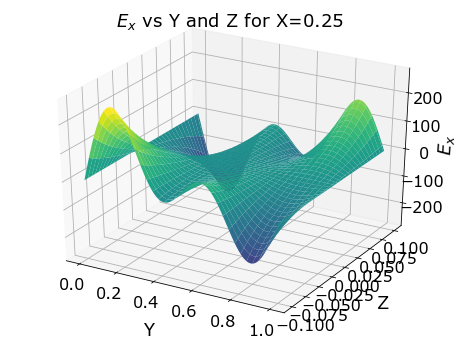

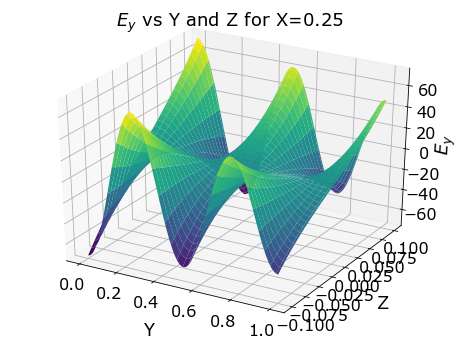

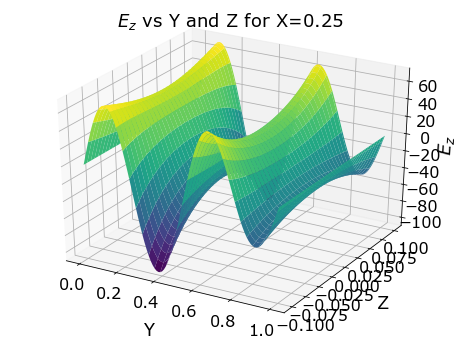

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Needed for 3D plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)

# We'll plot the 3 individual field components
for component in ['E_x', 'E_y', 'E_z']:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    # We reshape the 1D pandas columns into 2D arrays,
    # which is the format needed for the `plot_surface` arguments
    ax.plot_surface(df_slice.y.values.reshape((grid,-1)),    
                    df_slice.z.values.reshape((grid,-1)),
                    df_slice[component].values.reshape((grid,-1)),
                    cmap='viridis')
    ax.xaxis.labelpad = ax.yaxis.labelpad = 15
    plt.xlabel('Y')
    plt.ylabel('Z')
    ax.set_zlabel('$'+component+'$')
    plt.title('$'+component+'$ vs Y and Z for X=0.25')
plt.show()

(Note: if you're playing along at home, try using `%matplotlib notebook` instead of `%matplotlib inline`.  This will embed interactive plots which you can rotate to your heart's content.)

## Fitting

Now that we're able to visualize our data, let's try to model it via curve fitting.  First off, we shouldn't have to fit the full 1,030,301 data points generated in the previous step.  Let's take a small (n=10,000) randomly sampled subset of our initial data, and use that as our input:

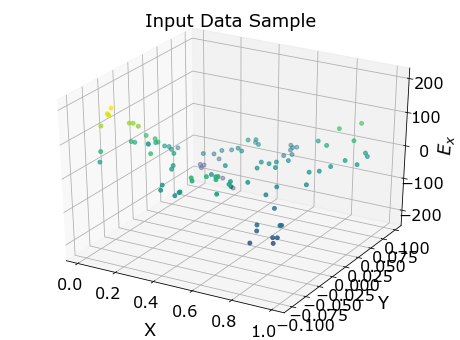

In [79]:
df_test = df_true.sample(n=10000) # Take 10,000 randomly sampled points; this will be our input data.

# Lets make a scatter plot of the input data for a single 2D plane.
df_test_slice = df_test.query('x==0.25')
fig=plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(df_test_slice.y, df_test_slice.z, df_test_slice.E_x, c=df_test_slice.E_x, s=15, cmap='viridis')
ax.xaxis.labelpad = ax.yaxis.labelpad = 15
plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel(r'$E_x$')
plt.title('Input Data Sample')
plt.show()

The data looks pretty messy, and it's not obvious that this could be uniquely modeled with a multidimensional parameterization.  But if we were really taking measurements for some sort of experiment, it's not always practical to make millions of uniform measurements.  Now that we have our input data, let's build our parameterization.  We assume we know the form of our parametric expression (a sum of trigonometric functions), but we don't know the values of the free parameters, $A_{m,n}$.

In [80]:
# x, y and z are our input independent parameters.
# 'ms' and 'ns' are the total number of 'm' and 'n' integers that dictate our sum.
# **As will be our free parameters, and they'll be named like A_1_1, A_1_2...
def electric_field_3d(x, y, z, M, N, **As):
    E_x = np.zeros_like(x)
    E_y = np.zeros_like(x)
    E_z = np.zeros_like(x)
    for m in range(1, M+1):
        for n in range(1, N+1):
            A = As[f'A_{m}_{n}']
            k = np.sqrt((m*np.pi)**2+(n*np.pi)**2)
            E_x += A*m*np.pi*np.cos(m*np.pi*x)*np.sin(n*np.pi*y)*np.sinh(k*z)
            E_y += A*n*np.pi*np.sin(m*np.pi*x)*np.cos(n*np.pi*y)*np.sinh(k*z)
            E_z += A*k*np.sin(m*np.pi*x)*np.sin(n*np.pi*y)*np.cosh(k*z)
    # We return our estimates for E_x, E_y, E_z
    # as a single long 1D array using 'concatenate'.
    # We will have to remember this order, and mimic it
    # when we input data (but that shouldn't be to hard).
    return np.concatenate([E_x, E_y, E_z])
    

Now that we have a function for parameterizing our electric field, let's build an `lmfit.Model` and initialize our free parameters:

In [81]:
import lmfit as lm
# We define our model and tell it which inputs are independent variables
model = lm.Model(electric_field_3d, independent_vars=['x','y','z'])
# Now we can define our free parameters and initialize them.
params = lm.Parameters()
params.add('M', value=M, vary=False) # ms and ns shouldn't vary, they just
params.add('N', value=N, vary=False) # let us decide when to truncate our sum
for m in range(1, M+1):
    for n in range(1, N+1):
        params.add(f'A_{m}_{n}', value=0) # We define our free params, for our 'N'*'M' number of terms


Now that we have our input data and our model, we can put everything together and do some curve fitting:

In [82]:
# Our inputs need to be concatenated into a 1D array, the same order as we defined in our model
samples = np.concatenate([df_test.E_x.values, df_test.E_y.values, df_test.E_z.values])
# Now we input the dependent and independent variables, the free parameters, and make a call to Model.fit
result = model.fit(samples, x=df_test.x.values, y=df_test.y.values, z=df_test.z.values, params=params)

# We can print the output of the fit, and we can compare it with the 'true' A_(m,n) that were used to generated.
print(result.fit_report())
print('True A values:')
for i in As_true:
    print(i, As_true[i])

[[Model]]
    Model(electric_field_3d)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 169
    # data points      = 30000
    # variables        = 20
    chi-square         = 1.1343e-23
    reduced chi-square = 3.7835e-28
    Akaike info crit   = -1894231.86
    Bayesian info crit = -1894065.68
[[Variables]]
    M:      5 (fixed)
    N:      4 (fixed)
    A_1_1:  1.25106601 +/- 8.2828e-17 (0.00%) (init = 0)
    A_1_2:  2.16097348 +/- 4.7877e-17 (0.00%) (init = 0)
    A_1_3:  3.4312e-04 +/- 2.9349e-17 (0.00%) (init = 0)
    A_1_4:  0.90699772 +/- 1.8731e-17 (0.00%) (init = 0)
    A_2_1:  0.44026767 +/- 4.7702e-17 (0.00%) (init = 0)
    A_2_2:  0.27701578 +/- 3.4736e-17 (0.00%) (init = 0)
    A_2_3:  0.55878063 +/- 2.3733e-17 (0.00%) (init = 0)
    A_2_4:  1.03668218 +/- 1.6037e-17 (0.00%) (init = 0)
    A_3_1:  1.19030242 +/- 2.9337e-17 (0.00%) (init = 0)
    A_3_2:  1.61645020 +/- 2.3866e-17 (0.00%) (init = 0)
    A_3_3:  1.25758354 +/- 1.7867e-17 (0.00%) (

The best-fit values look extremely close to our 'true' values.  Let's extract the results, use them to reconstruct a high-granularity 3D surface, and compare it to our input data:

In [83]:
# We evaluate the ModelResult using the high-granularity grid of x,y,z coordinates:
results_3_full = result.eval(x=df_true.x, y=df_true.y, z=df_true.z).reshape((3,-1))
init_3_full = result.eval(x=df_true.x, y=df_true.y, z=df_true.z, params=params).reshape((3,-1))
df_true['E_x_fit'] = results_3_full[0]
df_true['E_y_fit'] = results_3_full[1]
df_true['E_z_fit'] = results_3_full[2]
df_true['E_x_init'] = init_3_full[0]
df_true['E_y_init'] = init_3_full[1]
df_true['E_z_init'] = init_3_full[2]

Let's make one more set of plots, imaging the data, the best fit (as a green wireframe), and the initial fit (as a black dashed wireframe).  We'll tweak some parameters so it doesn't get too messy, but the results look good!  We've definitely fit our data.

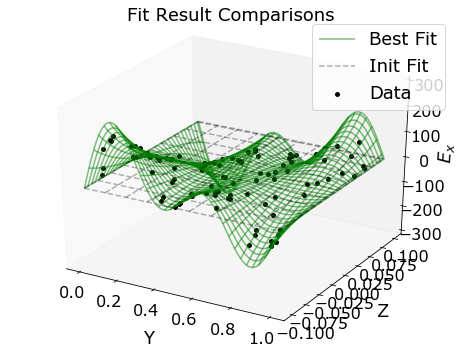

In [84]:
df_test_slice = df_test.query('x==0.25') # Looking at the same 2D slice
df_slice = df_true.query('x==0.25')      # from our initial plots

fig=plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(df_slice.y.values.reshape((grid,-1)),
                  df_slice.z.values.reshape((grid,-1)),
                  df_slice.E_x_fit.values.reshape((grid,-1)),
                  color='green', label='Best Fit', alpha=0.5)
ax.plot_wireframe(df_slice.y.values.reshape((grid,-1)),
                  df_slice.z.values.reshape((grid,-1)),
                  df_slice.E_x_init.values.reshape((grid,-1)),
                  color='k', label='Init Fit', alpha=0.3,
                  linestyle='--', rcount=10, ccount=10)
ax.scatter(df_test_slice.y, df_test_slice.z, df_test_slice.E_x,
           c='k', s=15, label='Data',
           depthshade=False, alpha=1, cmap='copper')
ax.xaxis.labelpad = ax.yaxis.labelpad = 15
ax.grid(False)
plt.xlabel('Y')
plt.ylabel('Z')
ax.set_zlabel(r'$E_x$')
plt.title('Fit Result Comparisons', pad=20)
plt.legend()
plt.show()

Brian Pollack, 2018